## Backtesting

In [373]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf

import keras.utils
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Flatten
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense,LeakyReLU,MaxPooling2D,Dropout
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from keras.utils.vis_utils import plot_model

In [374]:
def rename_datetime(data):
    data.rename(columns={'Unnamed: 0': 'datetime'},inplace=True)
    data['datetime']=pd.to_datetime(data['datetime'])
    data.set_index('datetime', inplace=True)
    return data

In [375]:
filepath='./../data/processed_data.csv'

In [376]:
feature_conditions = {
        'google_trends': 0, 'google_trends_lag': 0,
        'tweet_volume_lag': 0, 'tw_polarity_lag': 0, 'tw_compound': 0,
        'tw_polarity': 0, 'tweet_volume': 0,'re_compound': 0,'re_polarity': 0,
        're_subjectivity': 0
    }

In [377]:
# create features
def create_features(data, g_lag, tv_lag, tw_lag,thresh):
    data['return'] =data['Close'].pct_change().dropna()
    # data['Change']=data['Close'].diff().dropna()
    # data['return_change']=data['return'].diff().dropna()
    data['Label'] = np.where(data['return']>thresh, 1 ,0)
    # data['Label'] = np.where(data['return_change']<thresh, -1 ,data['Label'])
    data['tw_score_lag']=data['tw_compound'].shift(10)
    data['google_trends_lag']=data['google_trends'].shift(g_lag)
    data['tweet_volume_lag']=data['tweet_volume'].shift(tv_lag)
    data['tw_polarity_lag'] = data['tw_polarity'].shift(tw_lag)

    data.drop(columns=['Open','High','Low'],inplace=True)
    # Add features like RSI? Moving average?

    data.dropna(inplace=True)
    return data

In [378]:
def keep_features(feature_conditions):
    features=['Label','Close']
    for feature, condition in feature_conditions.items():
        if condition:
            features.append(feature)
    return features

In [379]:
def create_data(filepath, month, g_lag, tv_lag, tw_lag, thresh,feature_conditions,flag):
    # import data
    # import the original data. processed_data
    # processed_data: weighted reddit score+ fill the nan data
    data=pd.read_csv(filepath)
    # show the data
    data=rename_datetime(data)

    # create features
    data_created = create_features(data,g_lag,tv_lag,tw_lag,thresh)

    # get the subdata set
    if flag==0:
        data=data_created[data_created.index.month==month]
    else:
        data=data_created[(data_created.index.month>=1) & (data_created.index.month <=month)]

    # keep the wanted features
    features = keep_features(feature_conditions)
    data=data[features]
    return data

In [380]:
data = create_data(filepath, month=1, g_lag=2, tv_lag=28, tw_lag=3, thresh=0, feature_conditions=feature_conditions, flag=1)
display(data)

,Label,Close
datetime,,
2022-01-02 04:00:00,0,46902.11
2022-01-02 05:00:00,1,47077.70
2022-01-02 06:00:00,1,47122.49
2022-01-02 07:00:00,1,47171.04
2022-01-02 08:00:00,1,47211.36
...,...,...
2022-01-31 19:00:00,0,38400.00
2022-01-31 20:00:00,1,38432.32
2022-01-31 21:00:00,0,38395.17


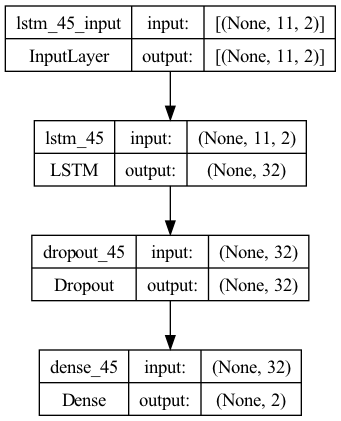

In [381]:
lstm_model= load_model('./saved_models/1_base_lstm_model.h5')
plot_model(lstm_model, to_file='./lstm_model.png', show_shapes=True, show_layer_names=True)

In [382]:
def reshape_features(data, to_keep=1, to_remove=1):
    variables = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    columns, names = list(), list()

    for i in range(to_keep, 0, -1):
        columns.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(variables)]

    for i in range(0, to_remove):
        columns.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(variables)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(variables)]

    #put it all together
    final = pd.concat(columns, axis=1)
    final.columns = names

    #drop rows with NaN values
    final.dropna(inplace=True)

    new_data = final.reset_index()

    new_data = new_data.drop(columns=['datetime'])

    return new_data

In [383]:
from tqdm import tqdm
import plotly.express as px
def run_simulator(timestep, data, amt, thresh, model, verbose, plot=True):
    curr_holding = False
    events_list = []
    init_amt = amt
    prices=data['Close']
    irowdata=data.iloc[timestep:]
    pred=1
    #go through dates
    i=0
    for date, r in tqdm(irowdata.iterrows(),total=len(irowdata)):

        #if you're currently holding the stock, sell it
        if curr_holding and pred<1-thresh:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))

            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        # date = pd.to_datetime(date)
        # #
        # # # Calculate start date using pd.Timedelta
        # start_date = date - pd.Timedelta(hours=timestep)
        # Calculate start date using pd.DateOffset
        curr_data=data[:date]

        features= len(curr_data.columns.values)
        df_copy = curr_data.copy()
        new_data=reshape_features(df_copy, timestep, 1)

        feature_scaler=MinMaxScaler()
        scale_test_data= feature_scaler.fit_transform(new_data)
        all_features = timestep * features

        test = scale_test_data[:, :all_features]
        input_data = test.reshape((test.shape[0], timestep, features))

        pred=model.predict(input_data,verbose=0)

        pred=pred[-1][1]

        if i==0:
            pred=1

        # If you predict a high enough return and not holding, buy stock
        if (not curr_holding) and pred > thresh:
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s' % buy_price)

        if 1-thresh<pred<thresh:
            events_list.append(('w', date))
        i=i+1

        #graph
    tot_return = round(100 * (amt / init_amt - 1), 2)
    print(tot_return)
    # if plot:
    #
    #     plt.figure(figsize=(10,4))
    #     plt.plot(prices[14:])
    #
    #     y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
    #     shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)
    #
    #     for idx, event in enumerate(events_list):
    #         # plt.axvline(event[1], color='k', linestyle='--', alpha=0.1)
    #         if event[0] == 's':
    #             plt.axvline(event[1], color='k', linestyle='--', alpha=0.1)
    #             color = 'green' if event[2] > 0 else 'red'
    #             plt.fill_betweenx(range(*shaded_y_lims),
    #                               event[1], events_list[idx-1][1], color=color, alpha=0.8)
    #
    #     tot_return = round(100*(amt / init_amt - 1), 2)
    #     tot_return = str(tot_return) + '%'
    #     plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%("Bitcoin", thresh, round(amt,2), tot_return), fontsize=20)
    #     plt.ylim(*y_lims)
    #     plt.show()
    if plot:
        tickerSymbol = 'BTC'

        fig = px.line(prices[timestep:], x=prices.index[timestep:], y=prices[timestep:], title=f"{tickerSymbol} Price Data",
                      labels={'Price': 'Price'},
                      line_shape='linear')

        y_lims = (int(prices.min() * .95), int(prices.max() * 1.05))
        shaded_y_lims = int(prices.min() * .5), int(prices.max() * 1.5)

        for idx, event in enumerate(events_list):

            if event[0] == 's':
                fig.add_shape(type="line", x0=event[1], x1=event[1], y0=shaded_y_lims[0], y1=shaded_y_lims[1],
                          line=dict(color='grey', dash='dash'), opacity=0.4)
                color = 'green' if event[2] > 0 else 'red'
                fig.add_shape(type="rect", x0=event[1], x1=events_list[idx - 1][1], y0=shaded_y_lims[0],
                              y1=shaded_y_lims[1], fillcolor=color, opacity=0.1)

        tot_return = round(100 * (amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'

        fig.update_layout(
            shapes=[dict(type='line', x0=event[1], x1=event[1], y0=shaded_y_lims[0], y1=shaded_y_lims[1],
                     line=dict(color='grey', dash='dash'), opacity=0.3) for event in events_list] +
                   [dict(type='rect', x0=event[1], x1=events_list[idx - 1][1], y0=shaded_y_lims[0],
                     y1=shaded_y_lims[1], fillcolor='green' if event[2] > 0 else 'red', opacity=0.5) for idx, event in enumerate(events_list) if event[0] == 's'],
            title=f"{tickerSymbol} Price Data\nThresh={thresh}\nTotal Amt: ${round(amt, 2)}\nTotal Return: {tot_return}",
            xaxis_title='Date',
            yaxis_title='Price',
            yaxis_range=y_lims
        )

        fig.show()


    return amt

In [384]:
amt=run_simulator(timestep=11, data=data, amt=100, thresh=0.51, model=lstm_model, verbose=0, plot=True)

100%|██████████| 705/705 [00:23<00:00, 30.37it/s]


-0.67
